/var/folders/kv/9rttrf4d247660zlsmn6dd080000gn/T/ipykernel_43420/1774281977.py:105: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(pca_result[mask, 0], pca_result[mask, 1], c=color, s=50, label=region)


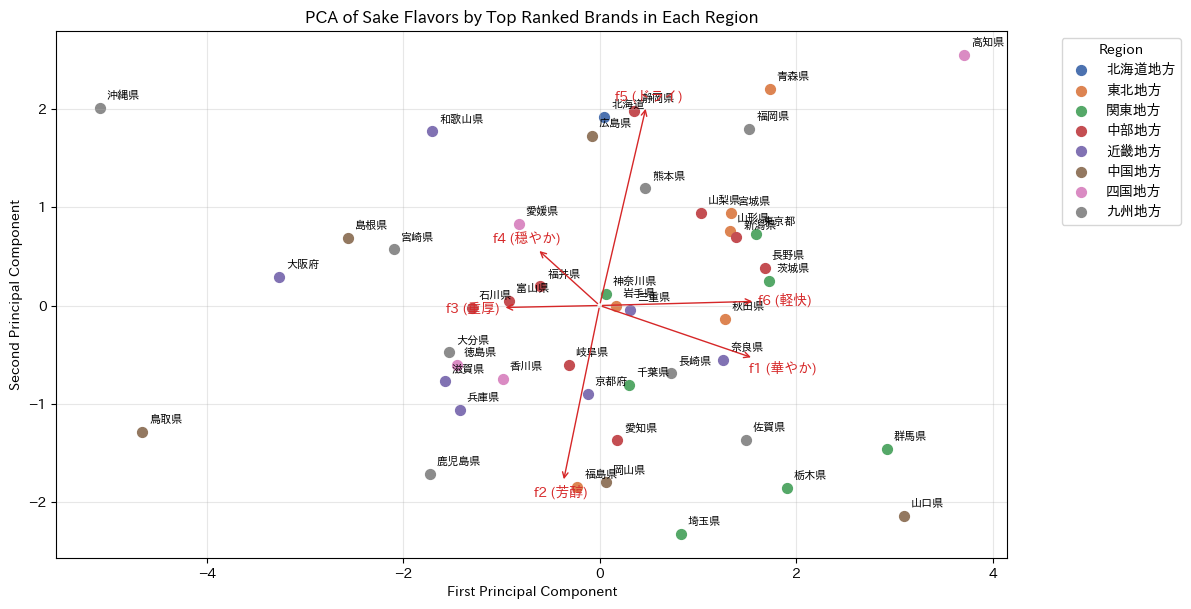

Explained variance ratio:
PC1: 0.5379
PC2: 0.2664
PC3: 0.1241
PC4: 0.0507
PC5: 0.0160
PC6: 0.0049

Feature contributions to principal components:

PC1:
f1 (華やか): 0.507
f2 (芳醇): -0.222
f3 (重厚): -0.521
f4 (穏やか): -0.363
f5 (ドライ): 0.051
f6 (軽快): 0.537

PC2:
f1 (華やか): -0.227
f2 (芳醇): -0.647
f3 (重厚): -0.022
f4 (穏やか): 0.211
f5 (ドライ): 0.696
f6 (軽快): 0.003


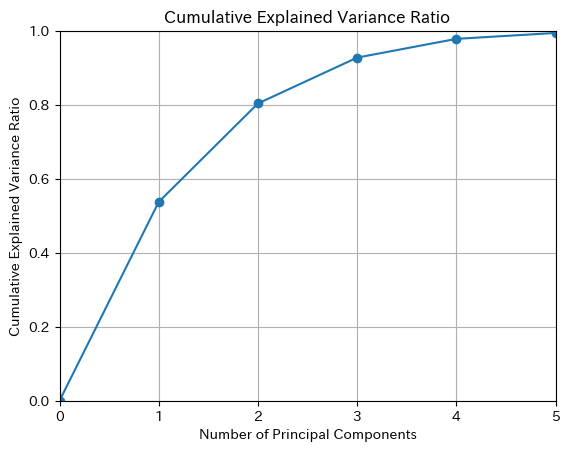

In [4]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import japanize_matplotlib # 追加
import seaborn as sns

# APIからデータを取得する関数
def get_api_data(endpoint):
    url = f"https://muro.sakenowa.com/sakenowa-data/api/{endpoint}"
    response = requests.get(url)
    return response.json()

# データの取得
brands = pd.DataFrame(get_api_data("brands")['brands'])
breweries = pd.DataFrame(get_api_data("breweries")['breweries'])
areas = pd.DataFrame(get_api_data("areas")['areas'])
flavor_charts = pd.DataFrame(get_api_data("flavor-charts")['flavorCharts'])
rankings = get_api_data("rankings")

# 地域ごとの上位10位の銘柄を抽出
area_rankings = rankings['areas']
top_brands = []
for area in area_rankings:
    if area['ranking']:
        top_brands.extend([rank['brandId'] for rank in area['ranking'][:10]])

# 必要なデータのみを結合
brands_reduced = brands[['id', 'name', 'breweryId']]
breweries_reduced = breweries[['id', 'areaId']]
areas_reduced = areas[['id', 'name']]
flavor_charts_reduced = flavor_charts[['brandId', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6']]

# データの結合
data = (brands_reduced.merge(breweries_reduced, left_on='breweryId', right_on='id', suffixes=('_brand', '_brewery'))
        .merge(areas_reduced, left_on='areaId', right_on='id', suffixes=('', '_area'))
        .merge(flavor_charts_reduced, left_on='id_brand', right_on='brandId'))

# 地域ごとの上位10位の銘柄のフレーバー特性を取得し、平均値を計算
top_brand_flavors = data[data['id_brand'].isin(top_brands)]
flavor_columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
top_brand_flavors_avg = top_brand_flavors.groupby('name_area')[flavor_columns].mean()

# データの標準化
scaler = StandardScaler()
scaled_data = scaler.fit_transform(top_brand_flavors_avg)

# 主成分分析の実行
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# # 地方ごとの色を設定
# region_colors = {
#     '北海道地方': '#ADD8E6', '東北地方': '#FFDAB9', '関東地方': '#90EE90',
#     '中部地方': '#FFB6C1', '近畿地方': '#DDA0DD', '中国地方': '#F5DEB3',
#     '四国地方': '#FFB6C1', '九州地方': '#D3D3D3'
# }

# seabornのdeepパレットから8色を取得
colors = sns.color_palette('deep', 8)

# 地方ごとの色を設定
region_colors = {
    '北海道地方': colors[0],
    '東北地方': colors[1],
    '関東地方': colors[2],
    '中部地方': colors[3],
    '近畿地方': colors[4],
    '中国地方': colors[5],
    '四国地方': colors[6],
    '九州地方': colors[7]
}

# 地域名と地方の対応を設定
prefecture_to_region = {
    '北海道': '北海道地方', '青森県': '東北地方', '岩手県': '東北地方', '宮城県': '東北地方',
    '秋田県': '東北地方', '山形県': '東北地方', '福島県': '東北地方', '茨城県': '関東地方',
    '栃木県': '関東地方', '群馬県': '関東地方', '埼玉県': '関東地方', '千葉県': '関東地方',
    '東京都': '関東地方', '神奈川県': '関東地方', '新潟県': '中部地方', '富山県': '中部地方',
    '石川県': '中部地方', '福井県': '中部地方', '山梨県': '中部地方', '長野県': '中部地方',
    '岐阜県': '中部地方', '静岡県': '中部地方', '愛知県': '中部地方', '三重県': '近畿地方',
    '滋賀県': '近畿地方', '京都府': '近畿地方', '大阪府': '近畿地方', '兵庫県': '近畿地方',
    '奈良県': '近畿地方', '和歌山県': '近畿地方', '鳥取県': '中国地方', '島根県': '中国地方',
    '岡山県': '中国地方', '広島県': '中国地方', '山口県': '中国地方', '徳島県': '四国地方',
    '香川県': '四国地方', '愛媛県': '四国地方', '高知県': '四国地方', '福岡県': '九州地方',
    '佐賀県': '九州地方', '長崎県': '九州地方', '熊本県': '九州地方', '大分県': '九州地方',
    '宮崎県': '九州地方', '鹿児島県': '九州地方', '沖縄県': '九州地方'
}

# 地域ごとの色を設定
top_brand_flavors_avg['region'] = top_brand_flavors_avg.index.map(prefecture_to_region)

# 結果の可視化
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_aspect('equal')

# 銘柄を散布図にプロット
# 第一主成分と第二主成分における観測変数の寄与度をプロットする
for region, color in region_colors.items():
    mask = top_brand_flavors_avg['region'] == region
    ax.scatter(pca_result[mask, 0], pca_result[mask, 1], c=color, s=50, label=region)
    for i, (idx, row) in enumerate(top_brand_flavors_avg[mask].iterrows()):
        ax.annotate(idx, (pca_result[mask, 0][i], pca_result[mask, 1][i]), 
                    xytext=(5, 5), textcoords='offset points', ha='left', va='bottom',
                    fontsize=8)

# 特徴量を矢印でプロット
for i, (feature, label) in enumerate(zip(flavor_columns, ['華やか', '芳醇', '重厚', '穏やか', 'ドライ', '軽快'])):
    ax.annotate(
        f"{feature} ({label})", xy=(0, 0), xytext=pca.components_[:2, i] * 3,
        color="tab:red", arrowprops=dict(arrowstyle='<-', color="tab:red")
    )

ax.grid(alpha=0.3)
ax.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PCA of Sake Flavors by Top Ranked Brands in Each Region')
plt.tight_layout()
plt.show()

# 主成分の寄与率を表示
print("Explained variance ratio:")
for i, ratio in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {ratio:.4f}")

# 各主成分に対する元の特徴量の寄与度を表示
print("\nFeature contributions to principal components:")
for i, component in enumerate(pca.components_[:2]):  # 最初の2つの主成分のみ表示
    print(f"\nPC{i+1}:")
    for j, value in enumerate(component):
        print(f"{flavor_columns[j]} ({['華やか', '芳醇', '重厚', '穏やか', 'ドライ', '軽快'][j]}): {value:.3f}")

# 累積寄与率のプロット
plt.figure(dpi=100)
# PC1の手前に0を追加
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), marker='o')
# y軸の範囲を0から1に設定
plt.ylim(0, 1)
# x軸の範囲を0から5に設定
plt.xlim(0, 5)
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.grid()
plt.show()
